<a href="https://colab.research.google.com/github/Oaybarf/FX/blob/main/Prueba_Github.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from datetime import datetime
import pytz

# Definir la zona horaria de Perú
timezone = pytz.timezone("America/Lima")

# Obtener la fecha y hora actual en Perú
current_time_peru = datetime.now(timezone)

# Crear un DataFrame con la fecha y hora actual
data = {
    "Fecha": [current_time_peru.strftime("%Y-%m-%d")],
    "Hora": [current_time_peru.strftime("%H:%M:%S")]
}

df = pd.DataFrame(data)
print(df)

        Fecha      Hora
0  2024-10-02  11:33:12


[*********************100%***********************]  1 of 1 completed

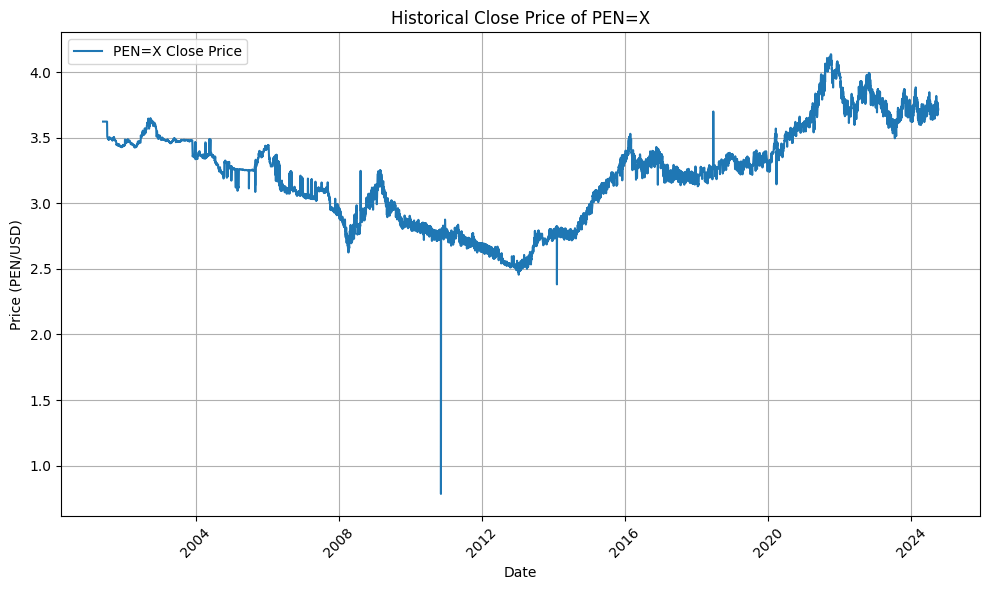

In [2]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd


stock_symbol = 'PEN=X' # USD
# stock_symbol = 'VSAT' # VIASAT
stock_data = yf.download(stock_symbol,  period="max")

# Agregar la columna de fechas basada en el índice
stock_data['Date'] = stock_data.index

# Resetear el índice para que no sea la columna Date
stock_data.reset_index(drop=True, inplace=True)

# Crear un rango de fechas completo desde el inicio hasta el final
dt_all = pd.date_range(start=stock_data['Date'].min(), end=stock_data['Date'].max())
dt_obs = [d.strftime("%Y-%m-%d") for d in pd.to_datetime(stock_data['Date'])]
dt_breaks = [d for d in dt_all.strftime("%Y-%m-%d").tolist() if not d in dt_obs]

# Graficar el precio de cierre histórico
plt.figure(figsize=(10, 6))
plt.plot(stock_data['Date'], stock_data['Close'], label=f"{stock_symbol} Close Price")
plt.title(f"Historical Close Price of {stock_symbol}")
plt.xlabel("Date")
plt.ylabel("Price (PEN/USD)")
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)  # Rotar las etiquetas del eje X para mejor legibilidad
plt.tight_layout()  # Ajustar el gráfico para evitar que se corten las etiquetas

plt.savefig('historical_close_price.png')  # Guardar en la carpeta 'output'

plt.show()
